# Developing Allometric Equations

In [1]:
import allometric_utils as au
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [3]:
df.columns

Index(['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'score', 'img_name',
       'tile_index', 'tile_xmin', 'tile_ymin', 'tile_xmax', 'tile_ymax', 'x',
       'y', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'X_d', 'Y_d', 'lon_d', 'lat_d',
       'is_musacea_d', 'is_banana', 'ground_index', 'name', 'lat_g', 'lon_g',
       'diameter', 'height', 'year', 'plot_id', 'tree_id', 'is_musacea_g',
       'site', 'X_g', 'Y_g', 'updated diameter', 'group', 'updated height',
       'AGB', 'carbon', 'id', 'unique_id'],
      dtype='object')

In [4]:
#check out the relationship between diameter and the bounding boxes 
df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['bbox_diagonal'] = ((df['xmax'] - df['xmin'])**2 + (df['ymax'] - df['ymin'])**2) ** 0.5

#bbox diameter as either the height or width, whichever is larger
df['bbox_across'] = np.where(df['xmax'] - df['xmin'] > df['ymax'] - df['ymin'], df['xmax'] - df['xmin'], df['ymax'] - df['ymin'])

In [5]:
#extract relevant columns 
df_relevant = df[['name', 'diameter', 'AGB']]

In [6]:
#combining everything under 80 to 'other'
df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_64849/4174086897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')


## Exploration of the Data

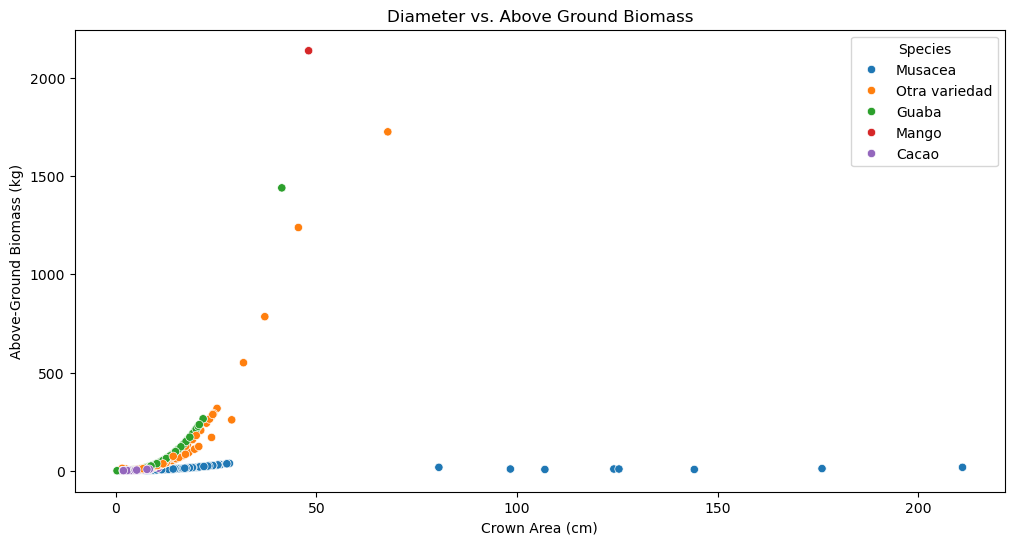

In [7]:
au.visualize_allometric_relationship(df_relevant, 'Diameter vs. Above Ground Biomass')

## Removing Outliers

In [9]:
df_cleaned = df_relevant.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'AGB')).reset_index(drop=True)
df_cleaned = df_cleaned.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'diameter')).reset_index(drop=True)


/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_64849/2114077081.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_relevant.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'AGB')).reset_index(drop=True)
/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_64849/2114077081.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('name').

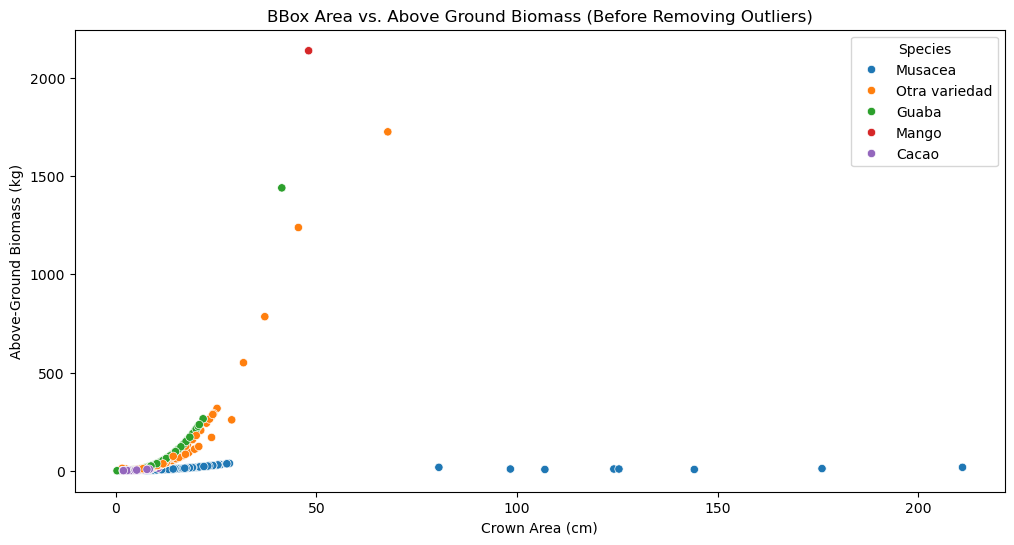

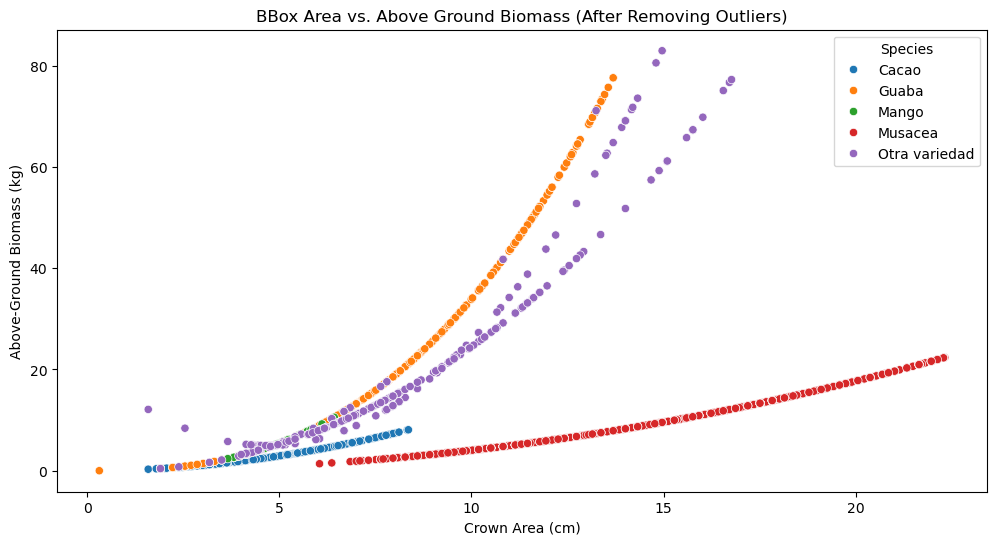

In [10]:
au.visualize_allometric_relationship(df_relevant, 'BBox Area vs. Above Ground Biomass (Before Removing Outliers)')
au.visualize_allometric_relationship(df_cleaned, 'BBox Area vs. Above Ground Biomass (After Removing Outliers)')

## Base model: Biomass=a×(Area)^b

Species: Cacao
Mean Squared Error: 8.801147895183682e-20
R^2 Score: 1.0
Intercept (a): 0.12079999997641222
Coefficient (b): 1.980000000118874


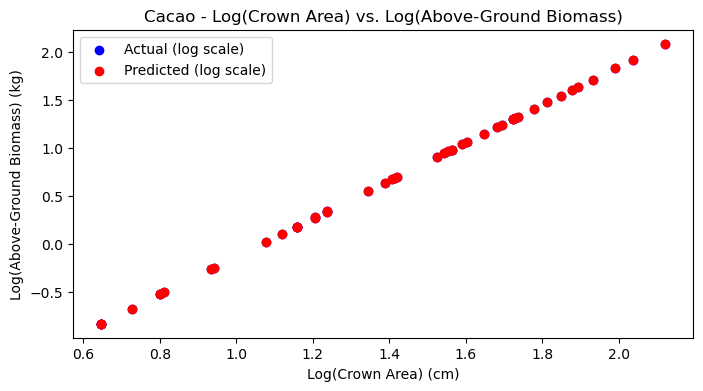

Species: Guaba
Mean Squared Error: 5.037849402156624e-19
R^2 Score: 1.0
Intercept (a): 0.07762471192515874
Coefficient (b): 2.6399999983559015


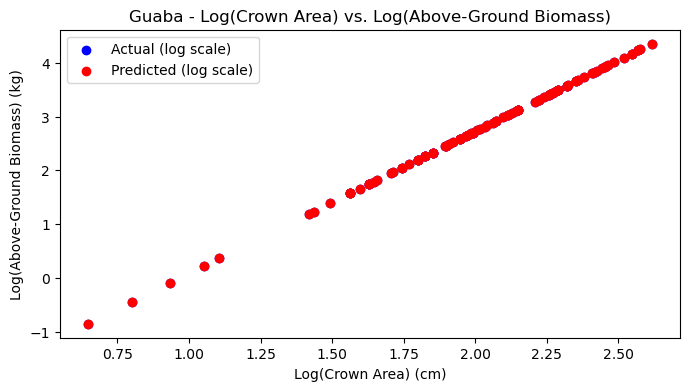

Species: Mango
Mean Squared Error: 2.4692823095432476e-20
R^2 Score: 1.0
Intercept (a): 0.07762471162836006
Coefficient (b): 2.6400000002768347


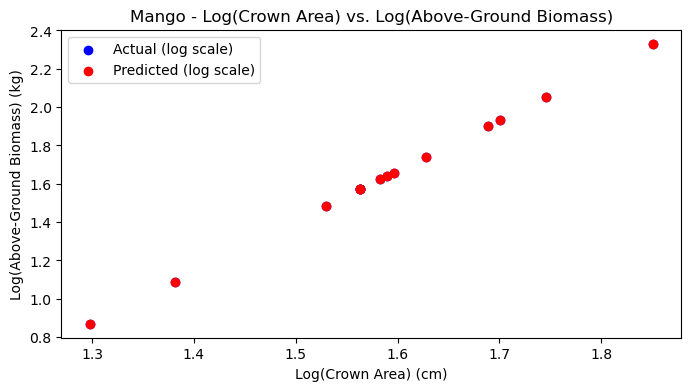

Species: Musacea
Mean Squared Error: 1.4773319065817465e-19
R^2 Score: 1.0
Intercept (a): 0.029999999994907964
Coefficient (b): 2.130000000076527


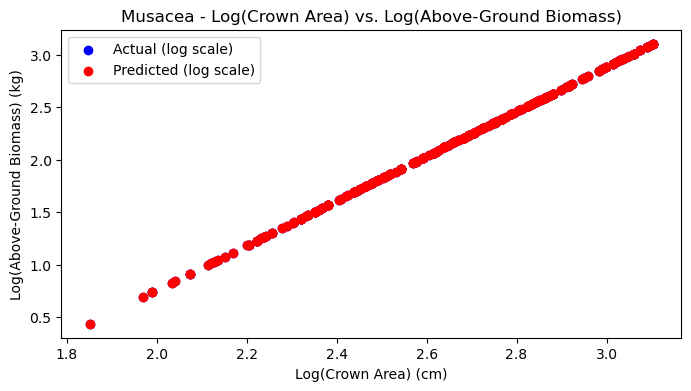

Species: Otra variedad
Mean Squared Error: 0.01905963303465127
R^2 Score: 0.9743846036895251
Intercept (a): 0.20901854562403224
Coefficient (b): 2.073656590770052


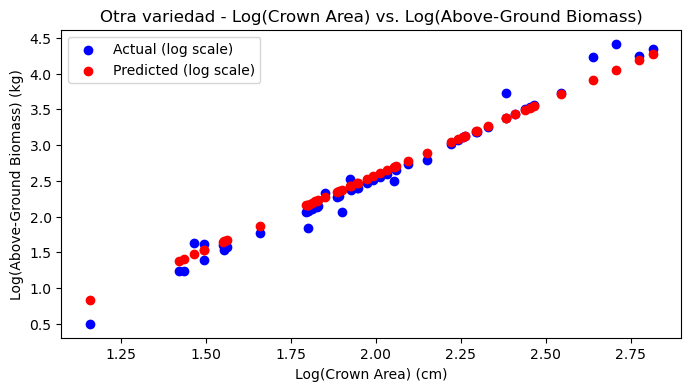

In [11]:
# List of unique species
species_list = df_cleaned['name'].unique()

# Fit and evaluate models for each species, and extract coefficients
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = au.fit_and_evaluate_log_log_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)


### Cross-Val Scores

In [14]:
def calculate_cross_val_score(models):
    for species, model in models.items():
        species_data = df_cleaned[df_cleaned['name'] == species]
        X = np.log(species_data[['diameter']])
        y = np.log(species_data['AGB'])
        
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        print(f'Species: {species}')
        print(f'Cross-Validation R^2 Scores: {scores}')
        print(f'Mean R^2 Score: {scores.mean()}')
    return scores

In [15]:
calculate_cross_val_score(models)

Species: Cacao
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Guaba
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Mango
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Musacea
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Otra variedad
Cross-Validation R^2 Scores: [0.94681794 0.97083005 0.60170506 0.96819051 0.96993725]
Mean R^2 Score: 0.8914961605588845


array([0.94681794, 0.97083005, 0.60170506, 0.96819051, 0.96993725])

### Linear Model

Species: Cacao
Mean Squared Error: 0.12135404112164502
R^2 Score: 0.9636641982981057
Intercept: -2.3466572026705235
Coefficient: 1.1188334976523278


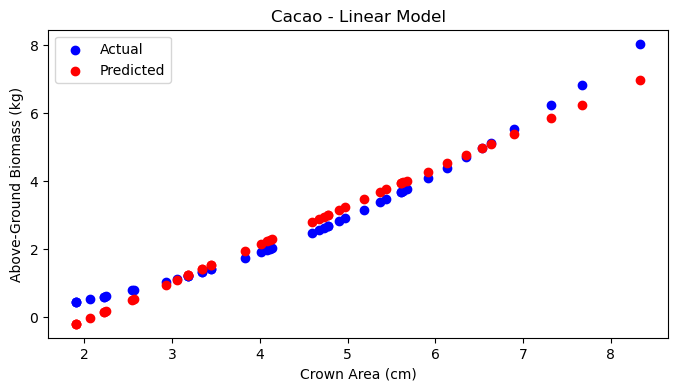

Species: Guaba
Mean Squared Error: 29.124211486558668
R^2 Score: 0.914009343393722
Intercept: -27.497440566554356
Coefficient: 6.345904741511031


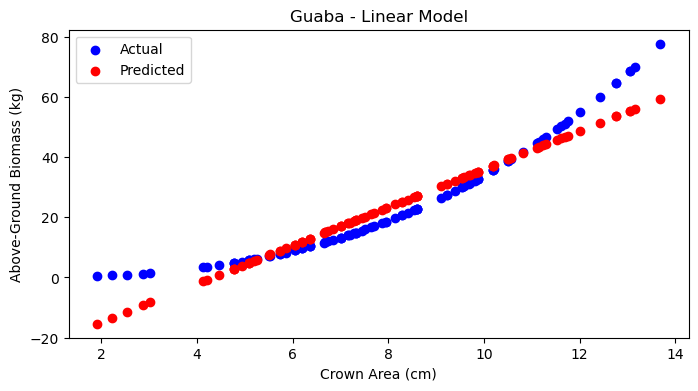

Species: Mango
Mean Squared Error: 0.10056427910234914
R^2 Score: 0.9722087521893281
Intercept: -9.591495967009822
Coefficient: 3.0489296895377427


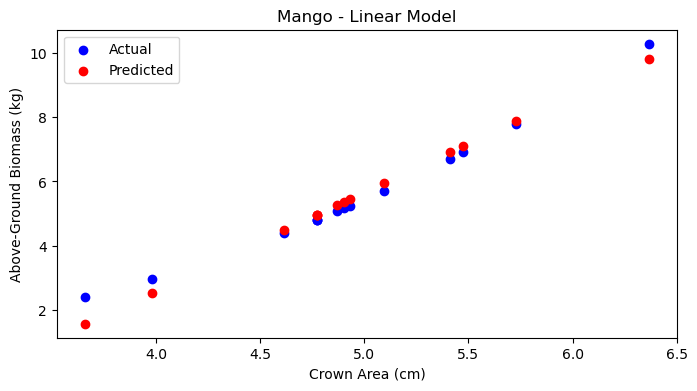

Species: Musacea
Mean Squared Error: 0.6007552789011465
R^2 Score: 0.9751949124265706
Intercept: -9.363091989151236
Coefficient: 1.3061008964434102


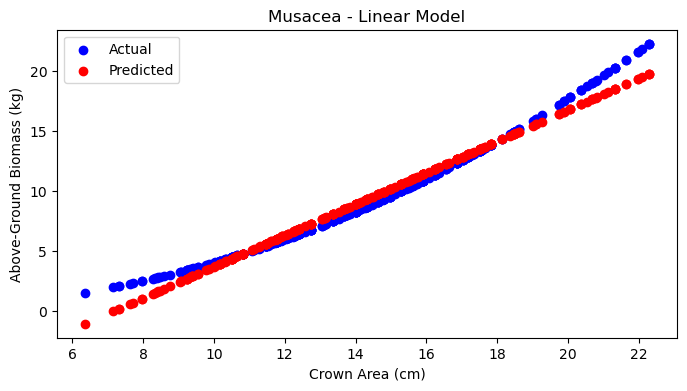

Species: Otra variedad
Mean Squared Error: 37.41787418218872
R^2 Score: 0.8956467795716853
Intercept: -24.612408057958003
Coefficient: 5.491952873562361


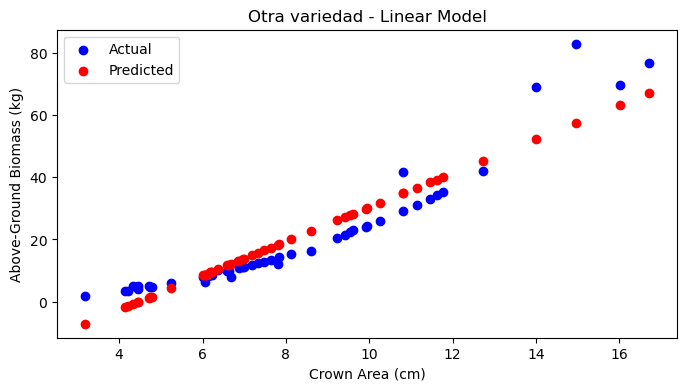

In [16]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = au.fit_and_evaluate_linear_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Exponential Model

Species: Cacao
Mean Squared Error: 0.403933841396547
R^2 Score: 0.8790542133907441
Intercept (a): 0.2726510090472438
Coefficient (b): 0.44918838592170135


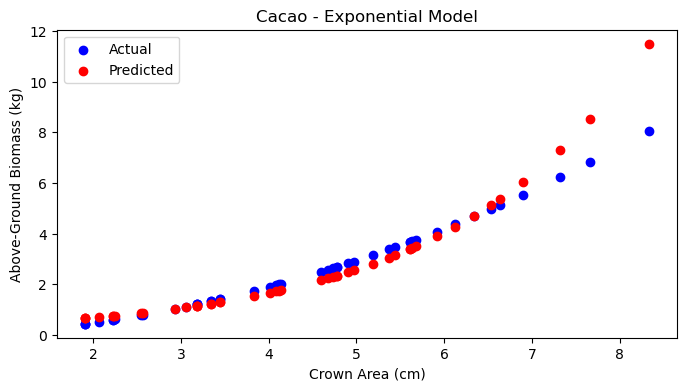

Species: Guaba
Mean Squared Error: 130.03808703860142
R^2 Score: 0.6160561980043857
Intercept (a): 0.7361898865822626
Coefficient (b): 0.3823764053127814


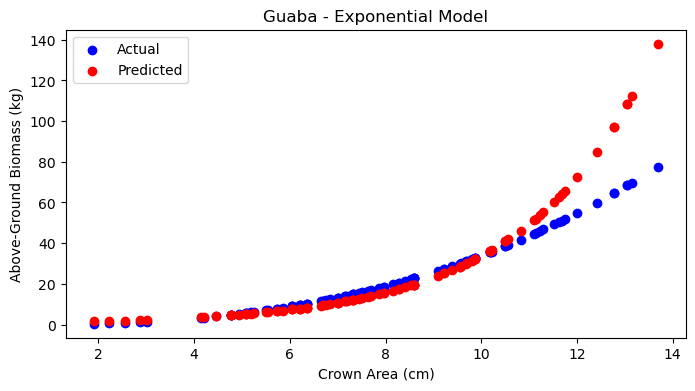

Species: Mango
Mean Squared Error: 0.03272937537026923
R^2 Score: 0.9909551364587627
Intercept (a): 0.3955992814568442
Coefficient (b): 0.5191174236203471


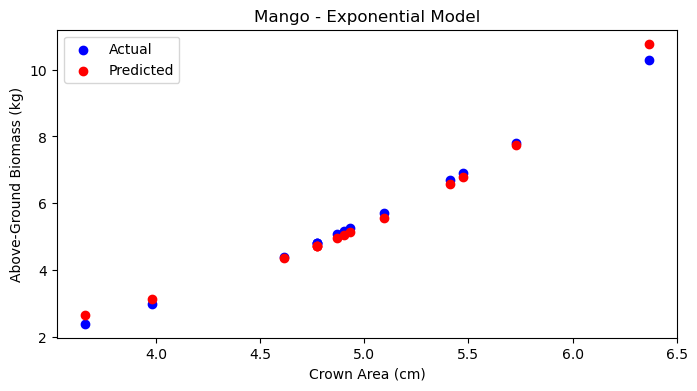

Species: Musacea
Mean Squared Error: 1.4705147219082586
R^2 Score: 0.9392826867511328
Intercept (a): 0.8783140502777927
Coefficient (b): 0.15526859750673794


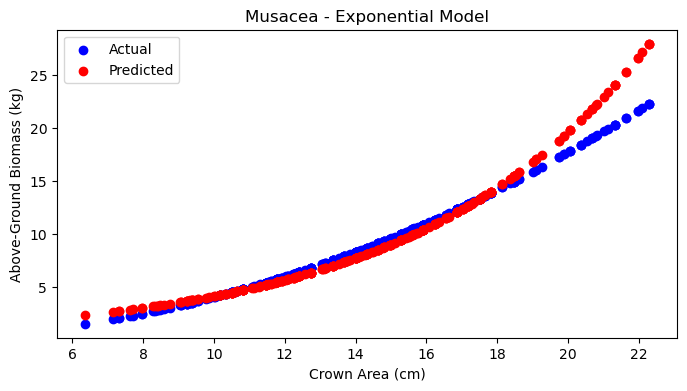

Species: Otra variedad
Mean Squared Error: 112.28615876754283
R^2 Score: 0.6868495997430086
Intercept (a): 1.511751086325891
Coefficient (b): 0.2695903015020811


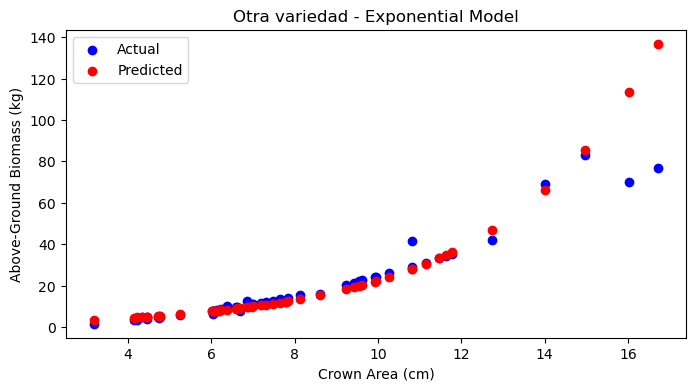

In [18]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = au.fit_and_evaluate_exponential_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Logarithmic Model

Species: Cacao
Mean Squared Error: 0.5035938078215516
R^2 Score: 0.8492140470133714
Intercept: -3.887677929367265
Coefficient: 4.595513707216883


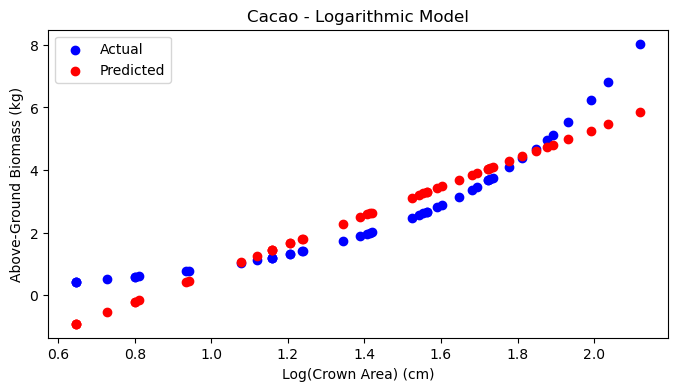

Species: Guaba
Mean Squared Error: 94.54517509822251
R^2 Score: 0.7208507536966684
Intercept: -49.293875586363626
Coefficient: 36.053203615973075


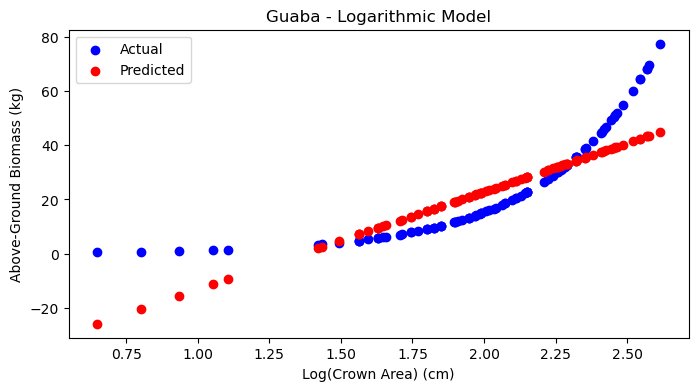

Species: Mango
Mean Squared Error: 0.2719874207413039
R^2 Score: 0.9248354397935471
Intercept: -18.71533175392257
Coefficient: 15.236590422814373


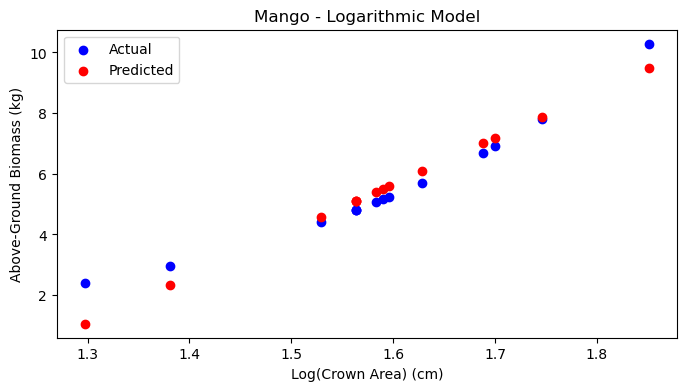

Species: Musacea
Mean Squared Error: 2.2348961941384706
R^2 Score: 0.907721500317851
Intercept: -35.77359448789598
Coefficient: 17.15352580584378


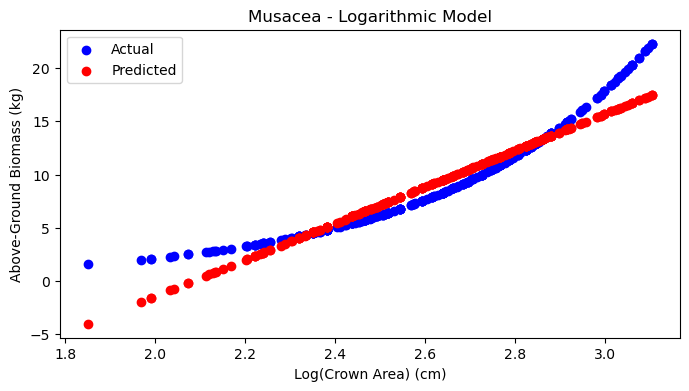

Species: Otra variedad
Mean Squared Error: 92.76544381455892
R^2 Score: 0.7412901449350893
Intercept: -56.25328128219543
Coefficient: 37.986836672077615


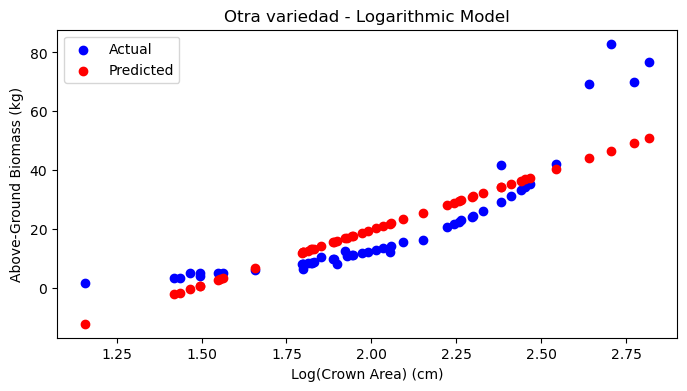

In [19]:
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = au.fit_and_evaluate_logarithmic_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)

### Polynomial Model 

Species: Cacao
Mean Squared Error: 7.807542236087519e-07
R^2 Score: 0.999999766226733


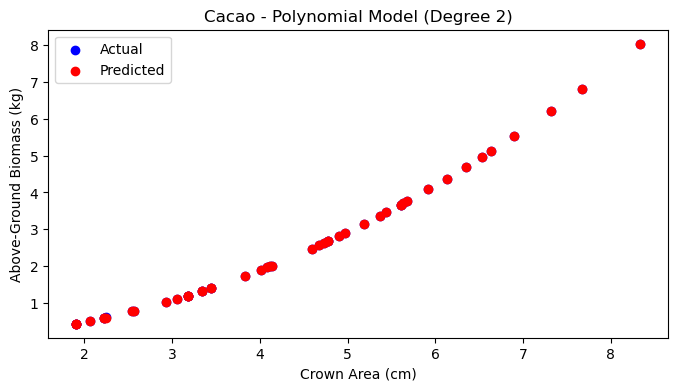

Species: Guaba
Mean Squared Error: 0.24451938788671768
R^2 Score: 0.9992780445669045


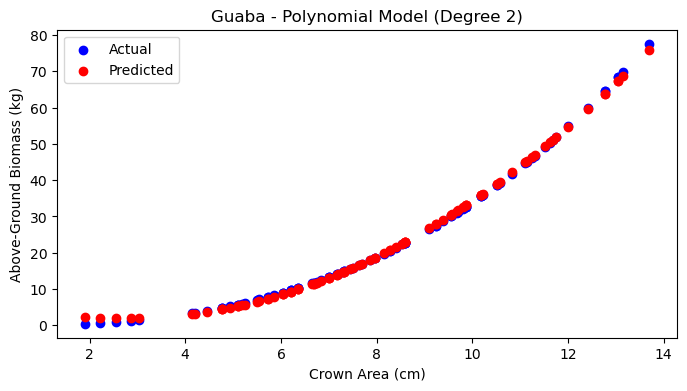

Species: Mango
Mean Squared Error: 0.00010630701432602128
R^2 Score: 0.9999706217296488


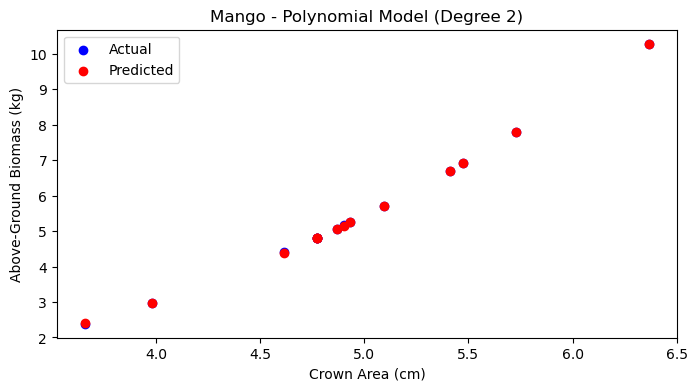

Species: Musacea
Mean Squared Error: 9.679052006606438e-05
R^2 Score: 0.9999960035351984


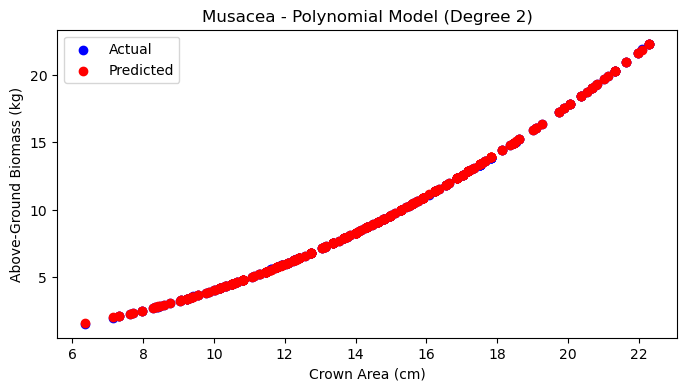

Species: Otra variedad
Mean Squared Error: 14.599161243583783
R^2 Score: 0.9592849801166579


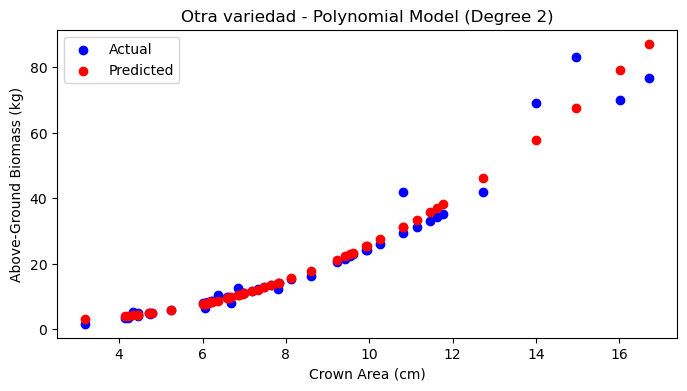

In [20]:
models = {}
coefficients = {}

for species in species_list:
    model, poly_coefficients = au.fit_and_evaluate_polynomial_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = poly_coefficients


In [22]:
#calculate cross validation scores for polynomial models

def calculate_cross_val_score_poly(models):
    for species, model in models.items():
        species_data = df_cleaned[df_cleaned['name'] == species]
        X = species_data[['diameter']]
        y = species_data['AGB']
        
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        print(f'Species: {species}')
        print(f'Cross-Validation R^2 Scores: {scores}')
        print(f'Mean R^2 Score: {scores.mean()}')
    return scores

calculate_cross_val_score_poly(models)

Species: Cacao
Cross-Validation R^2 Scores: [0.95810974 0.95845065 0.95298773 0.67243785 0.94495376]
Mean R^2 Score: 0.897387946550055
Species: Guaba
Cross-Validation R^2 Scores: [0.88031731 0.91236192 0.92696405 0.83332576 0.92741085]
Mean R^2 Score: 0.8960759794386226
Species: Mango
Cross-Validation R^2 Scores: [0.98213912 0.95749625 0.98474536 0.97967575 0.97867642]
Mean R^2 Score: 0.9765465797037832
Species: Musacea
Cross-Validation R^2 Scores: [0.96356583 0.97641973 0.97870549 0.96783474 0.95783964]
Mean R^2 Score: 0.9688730848721887
Species: Otra variedad
Cross-Validation R^2 Scores: [0.8932449  0.83944956 0.86411859 0.85990276 0.87868765]
Mean R^2 Score: 0.8670806922796427


array([0.8932449 , 0.83944956, 0.86411859, 0.85990276, 0.87868765])

### Generalized Addiive Model 

Species: Cacao
Mean Squared Error: 1.5607354273852243e-06
R^2 Score: 0.9999995620288641


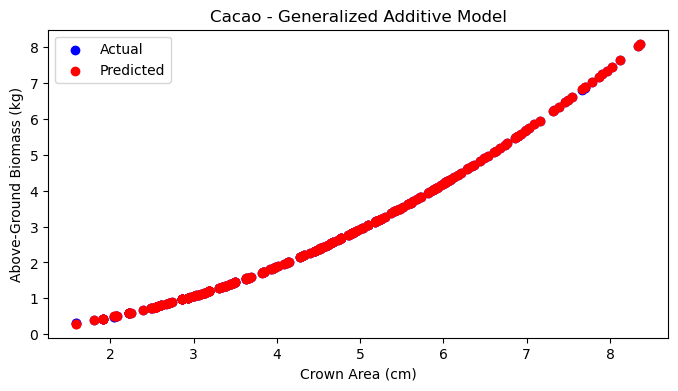

Species: Guaba
Mean Squared Error: 0.00028886580294451564
R^2 Score: 0.9999990918288059


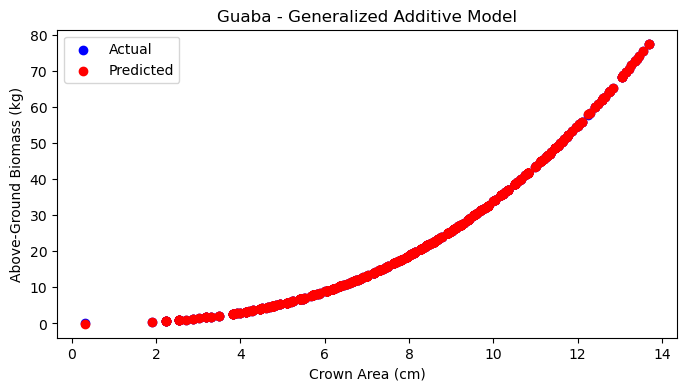

Species: Mango
Mean Squared Error: 2.6780369701675534e-06
R^2 Score: 0.9999994041733642


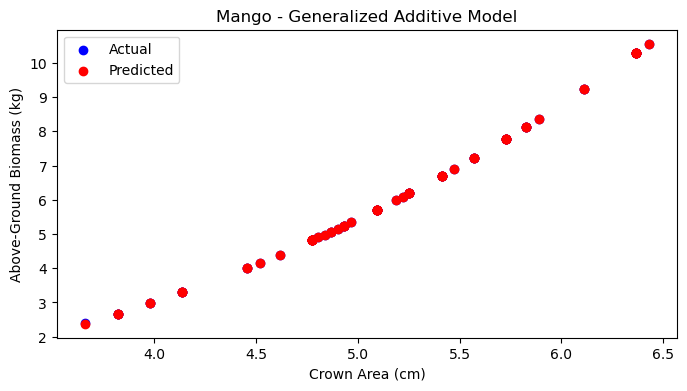

Species: Musacea
Mean Squared Error: 1.3161197818841347e-06
R^2 Score: 0.9999999412415383


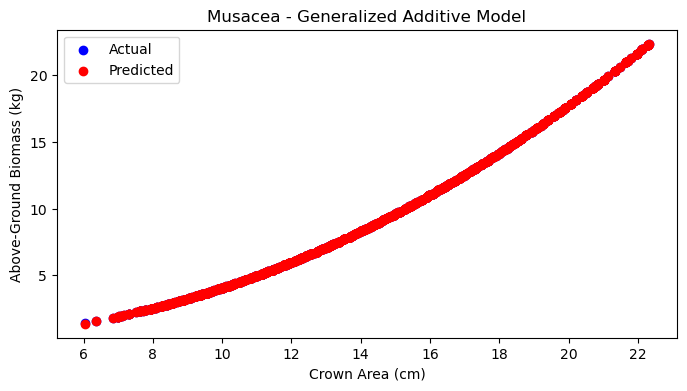

Species: Otra variedad
Mean Squared Error: 8.311409354832684
R^2 Score: 0.9772586558282818


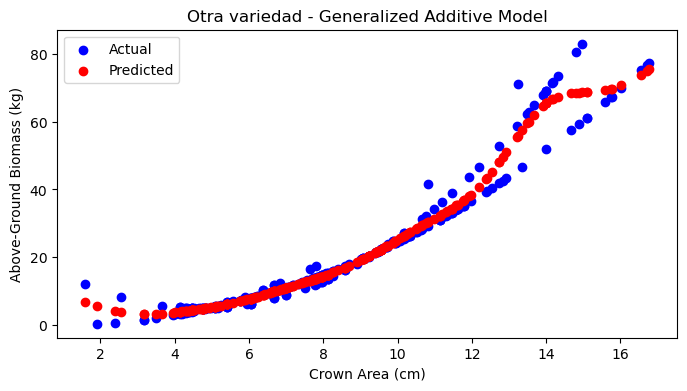

In [21]:
# Example usage
for species in species_list:
    model = au.fit_and_evaluate_gam_model(df_cleaned, species)


In [23]:
#calculate cross val scores for GAM models

def calculate_cross_val_score_gam(models):
    for species, model in models.items():
        species_data = df_cleaned[df_cleaned['name'] == species]
        X = species_data[['diameter']]
        y = species_data['AGB']
        
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        print(f'Species: {species}')
        print(f'Cross-Validation R^2 Scores: {scores}')
        print(f'Mean R^2 Score: {scores.mean()}')
    return scores

calculate_cross_val_score_gam(models)

Species: Cacao
Cross-Validation R^2 Scores: [0.95810974 0.95845065 0.95298773 0.67243785 0.94495376]
Mean R^2 Score: 0.897387946550055
Species: Guaba
Cross-Validation R^2 Scores: [0.88031731 0.91236192 0.92696405 0.83332576 0.92741085]
Mean R^2 Score: 0.8960759794386226
Species: Mango
Cross-Validation R^2 Scores: [0.98213912 0.95749625 0.98474536 0.97967575 0.97867642]
Mean R^2 Score: 0.9765465797037832
Species: Musacea
Cross-Validation R^2 Scores: [0.96356583 0.97641973 0.97870549 0.96783474 0.95783964]
Mean R^2 Score: 0.9688730848721887
Species: Otra variedad
Cross-Validation R^2 Scores: [0.8932449  0.83944956 0.86411859 0.85990276 0.87868765]
Mean R^2 Score: 0.8670806922796427


array([0.8932449 , 0.83944956, 0.86411859, 0.85990276, 0.87868765])

## Applying this to the whole spreadsheet

In [13]:
df_result = df_cleaned.copy()
df_result['AGB_predicted'] = df_cleaned.apply(
    lambda x: au.cacao(x['diameter'], coefficients) if x['name'] == 'Cacao' else
              au.guaba(x['diameter'], coefficients) if x['name'] == 'Guaba' else
              au.mango(x['diameter'], coefficients) if x['name'] == 'Mango' else
              au.musacea(x['diameter'], coefficients) if x['name'] == 'Musacea' else
              au.other(x['diameter'], coefficients),
    axis=1
)

df_result['AGB_difference'] = np.abs(df_result['AGB'] - df_result['AGB_predicted'])

# Flag significant differences (e.g., differences greater than 10% of the actual AGB)
df_result['AGB_difference_flag'] = df_result.apply(
    lambda x: 'Yes' if x['AGB_difference'] >= 0.1 * x['AGB'] else 'No', axis=1
)


In [14]:
df_result['AGB_difference_flag'].value_counts()

AGB_difference_flag
No     1611
Yes     877
Name: count, dtype: int64

In [15]:
#show 20 of the rows with the highest differences
df_result.sort_values(by='AGB_difference', ascending=False).head(20)

,name,diameter,AGB,bbox_area,bbox_diagonal,AGB_predicted,AGB_difference,AGB_difference_flag
1836,Musacea,211.038961,17.218058,89367.409044,422.831849,672.303206,655.085148,Yes
2396,Otra variedad,67.799847,1725.128436,166862.642885,577.689854,2320.047460,594.919024,Yes
1577,Musacea,176.024955,10.982186,54400.954439,330.003475,500.256831,489.274645,Yes
842,Musacea,144.194041,6.414421,49556.278853,314.865058,361.450917,355.036496,Yes
2464,Otra variedad,45.518207,1238.159783,53053.366080,325.767120,916.780849,321.378934,Yes
1118,Musacea,125.413802,8.700266,33915.678351,260.609580,287.944520,279.244254,Yes
1074,Musacea,124.140565,8.700266,32107.078847,253.903348,283.196749,274.496483,Yes
2012,Musacea,106.951872,6.414421,34659.051196,263.812393,222.141377,215.726956,Yes
2481,Otra variedad,37.146677,784.238541,34500.858348,264.744943,570.935890,213.302651,Yes
1245,Musacea,98.357525,8.700266,69788.540463,373.693445,193.799745,185.099479,Yes


In [16]:
#show the 20 rows with the highest differences, excluding otra variedad name 
df_result[df_result['name'] != 'Otra variedad'].sort_values(by='AGB_difference', ascending=False).head(20)

,name,diameter,AGB,bbox_area,bbox_diagonal,AGB_predicted,AGB_difference,AGB_difference_flag
1836,Musacea,211.038961,17.218058,89367.409044,422.831849,672.303206,655.085148,Yes
1577,Musacea,176.024955,10.982186,54400.954439,330.003475,500.256831,489.274645,Yes
842,Musacea,144.194041,6.414421,49556.278853,314.865058,361.450917,355.036496,Yes
1118,Musacea,125.413802,8.700266,33915.678351,260.609580,287.944520,279.244254,Yes
1074,Musacea,124.140565,8.700266,32107.078847,253.903348,283.196749,274.496483,Yes
2012,Musacea,106.951872,6.414421,34659.051196,263.812393,222.141377,215.726956,Yes
1245,Musacea,98.357525,8.700266,69788.540463,373.693445,193.799745,185.099479,Yes
1808,Musacea,80.532213,17.218058,61424.910076,350.516366,139.915449,122.697391,Yes
1688,Musacea,28.329514,37.186951,116106.118315,538.977403,25.502911,11.684040,Yes
1855,Musacea,27.692895,35.429569,49850.249042,315.815066,24.575766,10.853803,Yes


In [25]:
df['bbox_across']

0       345.524014
1       269.052490
2       207.246704
3       170.116211
4       189.865768
           ...    
2597    345.177384
2598    284.568115
2599    283.952393
2600    180.583374
2601    210.154181
Name: bbox_across, Length: 2602, dtype: float64

In [23]:
#looking at the relationship between bbox diagonal and diameter
import statsmodels.api as sm

# Prepare the data
X = df[['bbox_across']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['diameter']

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               diameter   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.638
Date:                Wed, 07 Aug 2024   Prob (F-statistic):              0.201
Time:                        17:19:01   Log-Likelihood:                -9376.7
No. Observations:                2602   AIC:                         1.876e+04
Df Residuals:                    2600   BIC:                         1.877e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5113      0.495     25.250      

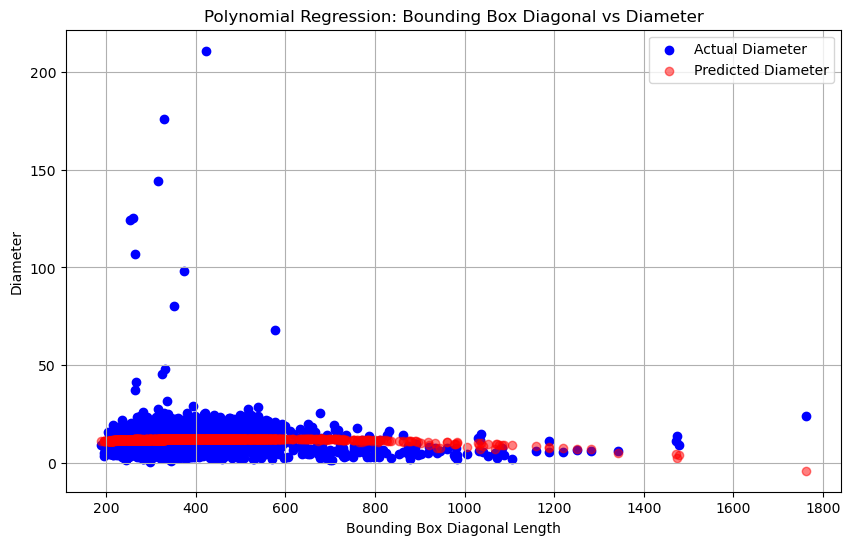

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Prepare polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['bbox_across']])
model_poly = LinearRegression().fit(X_poly, df['diameter'])
df['diameter_pred'] = model_poly.predict(X_poly)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(df['bbox_diagonal'], df['diameter'], color='blue', label='Actual Diameter')
plt.scatter(df['bbox_diagonal'], df['diameter_pred'], color='red', label='Predicted Diameter', alpha=0.5)
plt.xlabel('Bounding Box Diagonal Length')
plt.ylabel('Diameter')
plt.title('Polynomial Regression: Bounding Box Diagonal vs Diameter')
plt.legend()
plt.grid(True)
plt.show()


## Converting pixel bbox measurements into real world measurements

In [58]:
import pandas as pd
from geopy.distance import great_circle

def calculate_area(lat_min, lat_max, lon_min, lon_max):
    '''
    Calculate the area covered by the bounding box defined by latitude and longitude.
    
    Parameters:
    - lat_min, lat_max: Latitude boundaries of the bounding box
    - lon_min, lon_max: Longitude boundaries of the bounding box
    
    Returns:
    - area: Area covered by the bounding box in square meters
    '''
    # Convert lat/lon to points
    points = [(lat_min, lon_min), (lat_min, lon_max), (lat_max, lon_max), (lat_max, lon_min)]
    
    # Calculate the distances between consecutive points (edges of the bounding box)
    edge1 = great_circle(points[0], points[1]).meters  # Distance between (lat_min, lon_min) and (lat_min, lon_max)
    edge2 = great_circle(points[1], points[2]).meters  # Distance between (lat_min, lon_max) and (lat_max, lon_max)
    
    # Approximate the area (rectangular approximation)
    area = edge1 * edge2
    
    return area

# Example data
data = {
    "name": ["Leonor Aspiazu RGB", "Nestor Macias RGB", "Carlos Vera Arteaga RGB", "Flora Pluas RGB", "Carlos Vera Guevara RGB", "Manuel Macias RGB"],
    "lat_min": [-1.151065669, -2.181592854, -1.201982022, -2.230135558, -1.19892896, -1.129809132],
    "lat_max": [-1.150245509, -2.180796894, -1.201137032, -2.229286658, -1.19812554, -1.129191972],
    "lon_min": [-79.58001038, -79.5766559, -79.59362331, -79.54184103, -79.59148142, -79.59472671],
    "lon_max": [-79.57905014, -79.57570863, -79.59278379, -79.54106441, -79.59080769, -79.5938108]
}

df = pd.DataFrame(data)

# Calculate area for each orthomosaic
df['area_m2'] = df.apply(lambda row: calculate_area(row['lat_min'], row['lat_max'], row['lon_min'], row['lon_max']), axis=1)

print(df[['name', 'area_m2']])


                      name      area_m2
0       Leonor Aspiazu RGB  9735.581632
1        Nestor Macias RGB  9315.824693
2  Carlos Vera Arteaga RGB  8769.164463
3          Flora Pluas RGB  8145.302389
4  Carlos Vera Guevara RGB  6691.209207
5        Manuel Macias RGB  6987.749111


In [59]:
num_tiles_dict = {
    "Leonor Aspiazu RGB": 20,
    "Nestor Macias RGB": 16,
    "Carlos Vera Arteaga RGB": 16,
    "Flora Pluas RGB": 21,
    "Carlos Vera Guevara RGB": 16,
    "Manuel Macias RGB": 12
}

df['num_tiles'] = df['name'].map(num_tiles_dict)

In [60]:
#calculate the area per tile
df['area_per_tile'] = df['area_m2'] / df['num_tiles']

In [62]:
total_pixels_in_tile = 4000 * 4000

In [63]:
df['area_per_pixel'] = df['area_per_tile'] / total_pixels_in_tile

In [64]:
df

,name,lat_min,lat_max,lon_min,lon_max,area_m2,num_tiles,area_per_tile,area_per_pixel
0,Leonor Aspiazu RGB,-1.151066,-1.150246,-79.580010,-79.579050,9735.581632,20,486.779082,0.000030
1,Nestor Macias RGB,-2.181593,-2.180797,-79.576656,-79.575709,9315.824693,16,582.239043,0.000036
2,Carlos Vera Arteaga RGB,-1.201982,-1.201137,-79.593623,-79.592784,8769.164463,16,548.072779,0.000034
3,Flora Pluas RGB,-2.230136,-2.229287,-79.541841,-79.541064,8145.302389,21,387.871542,0.000024
4,Carlos Vera Guevara RGB,-1.198929,-1.198126,-79.591481,-79.590808,6691.209207,16,418.200575,0.000026
5,Manuel Macias RGB,-1.129809,-1.129192,-79.594727,-79.593811,6987.749111,12,582.312426,0.000036


In [65]:
df_old = pd.read_csv('final_dataset_filtered.csv') 

In [66]:
#check out the relationship between diameter and the bounding boxes 
df_old['bbox_area'] = (df_old['xmax'] - df_old['xmin']) * (df_old['ymax'] - df_old['ymin'])
df_old['bbox_diagonal'] = ((df_old['xmax'] - df_old['xmin'])**2 + (df_old['ymax'] - df_old['ymin'])**2) ** 0.5

#bbox diameter as either the height or width, whichever is larger
df_old['bbox_across'] = np.where(df_old['xmax'] - df_old['xmin'] > df_old['ymax'] - df_old['ymin'], df_old['xmax'] - df_old['xmin'], df_old['ymax'] - df_old['ymin'])

In [71]:
df_old['overall picture'] = df_old['img_path'].str.split('RGB').str[0] + 'RGB'

In [77]:
df_old['overall picture'].value_counts()

overall picture
Carlos Vera Guevara RGB    591
Flora Pluas RGB            547
Nestor Macias RGB          542
Leonor Aspiazu RGB         368
Carlos Vera Arteaga RGB    355
Manuel Macias RGB          199
Name: count, dtype: int64

In [82]:
def apply_changes(name, df, df_col_name, factor): 
    condition = df[df_col_name] == name
    df.loc[condition, 'bbox_area'] = df.loc[condition, 'bbox_area'] * factor
    df.loc[condition, 'bbox_diagonal'] = df.loc[condition, 'bbox_diagonal'] * factor
    df.loc[condition, 'bbox_across'] = df.loc[condition, 'bbox_across'] * factor

In [83]:
apply_changes('Carlos Vera Arteaga RGB', df_old, 'overall picture', 0.000034)
apply_changes('Carlos Vera Guevara RGB', df_old, 'overall picture', 0.000026)
apply_changes('Flora Pluas RGB', df_old, 'overall picture', 0.000024)
apply_changes('Leonor Aspiazu RGB', df_old, 'overall picture', 0.000030)
apply_changes('Manuel Macias RGB', df_old, 'overall picture', 0.000036)
apply_changes('Nestor Macias RGB', df_old, 'overall picture', 0.000036)

In [85]:
#extract relevant columns 
df_relevant = df_old[['name', 'diameter', 'AGB', 'bbox_area', 'bbox_diagonal']]

In [86]:
#combining everything under 80 to 'other'
df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_44185/4174086897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')


In [91]:
df_relevant

,name,diameter,AGB,bbox_area,bbox_diagonal
0,Musacea,10.281385,4.293300,2.954106,0.012402
1,Musacea,13.528139,7.702971,1.617564,0.009224
2,Musacea,12.732366,6.769828,1.088540,0.007525
3,Musacea,9.867583,3.933601,0.714499,0.006099
4,Musacea,17.825312,13.862143,0.884334,0.006787
...,...,...,...,...,...
2597,Otra variedad,8.404929,16.643291,4.081431,0.017153
2598,Guaba,8.785332,24.072524,2.676596,0.013907
2599,Cacao,8.359419,8.090504,1.275039,0.011165
2600,Cacao,5.220658,3.185392,1.114185,0.008963


## Exploration of the Data

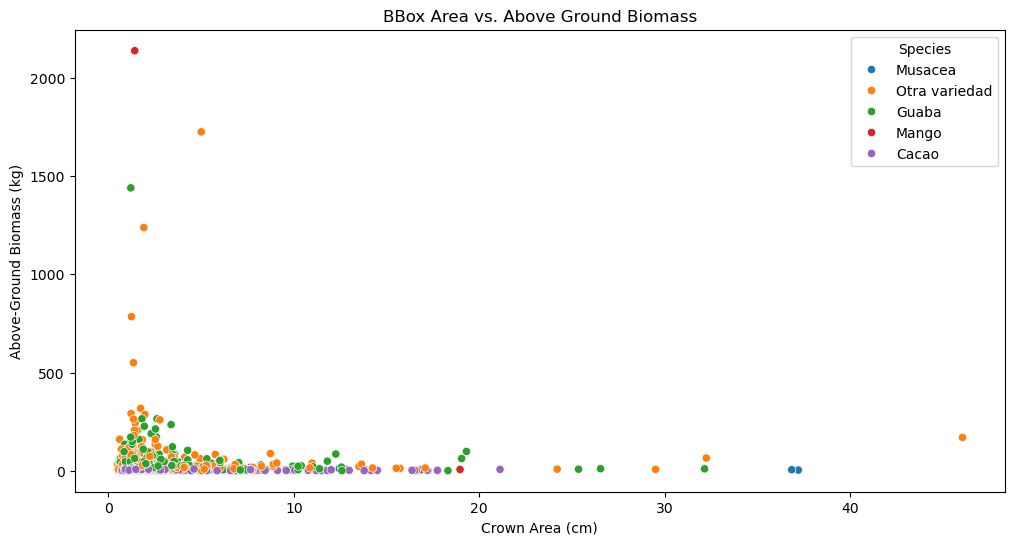

In [87]:
au.visualize_allometric_relationship(df_relevant, 'BBox Area vs. Above Ground Biomass')

## Removing Outliers

In [88]:
df_cleaned = df_relevant.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'AGB')).reset_index(drop=True)
df_cleaned = df_cleaned.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'bbox_area')).reset_index(drop=True)


/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_44185/1872997914.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_relevant.groupby('name').apply(lambda x: au.remove_outliers_iqr(x, 'AGB')).reset_index(drop=True)
/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_44185/1872997914.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('name').

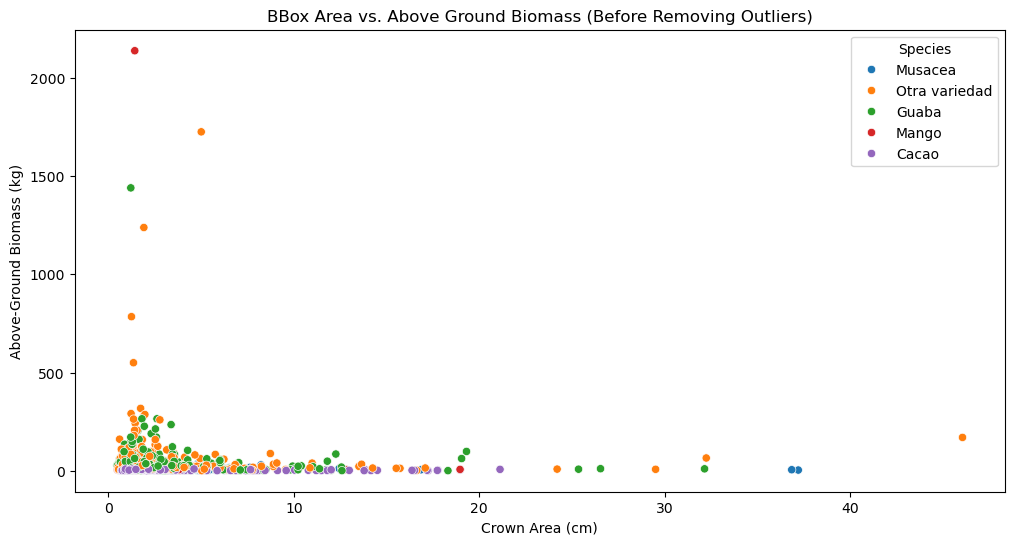

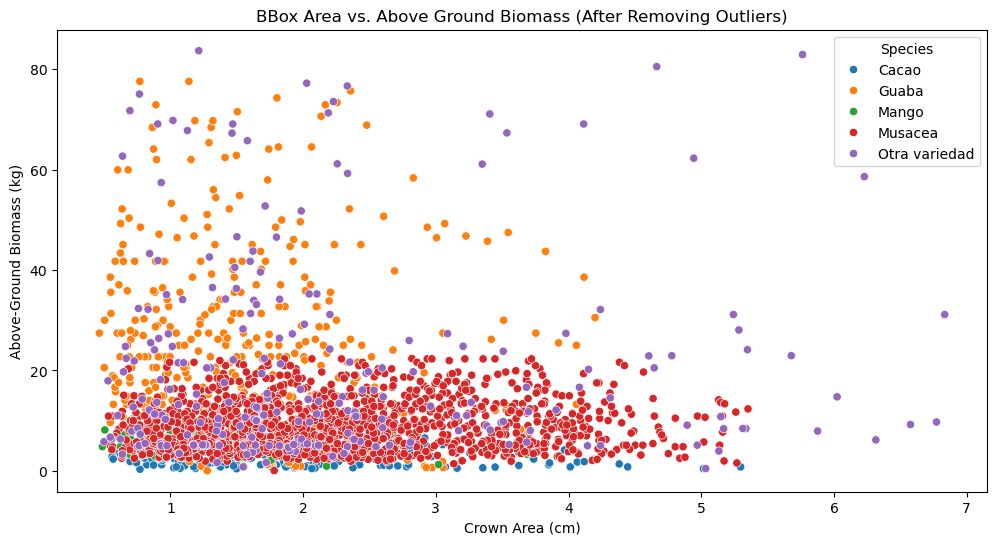

In [89]:
au.visualize_allometric_relationship(df_relevant, 'BBox Area vs. Above Ground Biomass (Before Removing Outliers)')
au.visualize_allometric_relationship(df_cleaned, 'BBox Area vs. Above Ground Biomass (After Removing Outliers)')

## Base model: Biomass=a×(Area)^b

Species: Cacao
Mean Squared Error: 0.43433336530074473
R^2 Score: 0.0629132857535083
Intercept (a): 2.34214636705207
Coefficient (b): -0.12027321279240878


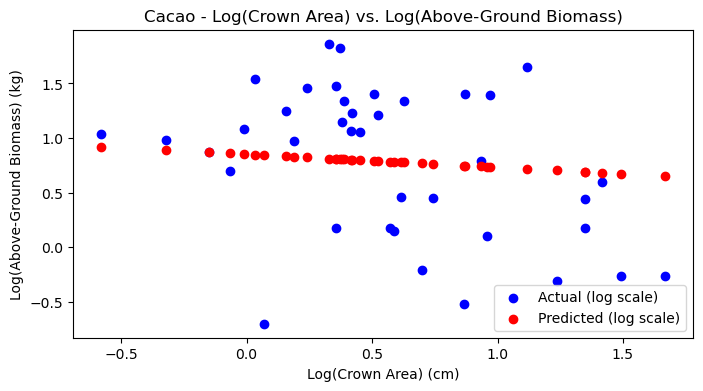

Species: Guaba
Mean Squared Error: 0.8567810053322725
R^2 Score: 0.034235944422887576
Intercept (a): 17.501443375352814
Coefficient (b): -0.2800122280720117


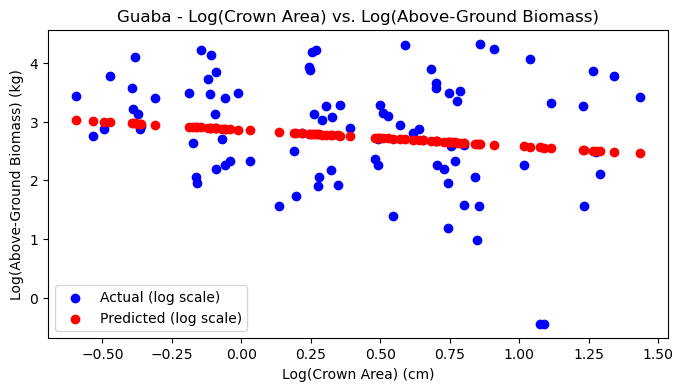

Species: Mango
Mean Squared Error: 0.31952031852389856
R^2 Score: -0.0015407057591747542
Intercept (a): 5.417755277468367
Coefficient (b): -0.19810808417955092


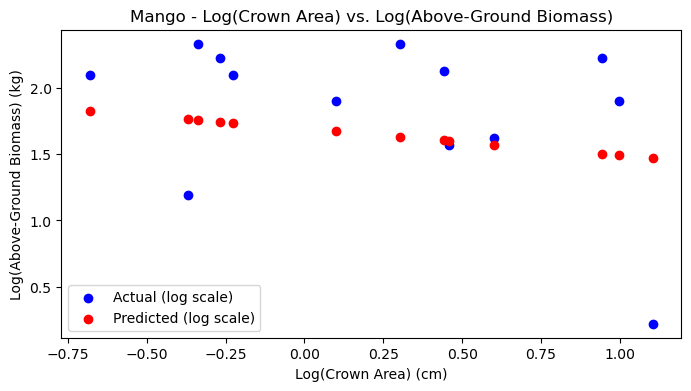

Species: Musacea
Mean Squared Error: 0.3004508498404607
R^2 Score: 0.009754613169306037
Intercept (a): 7.575253854902053
Coefficient (b): 0.06307715279222706


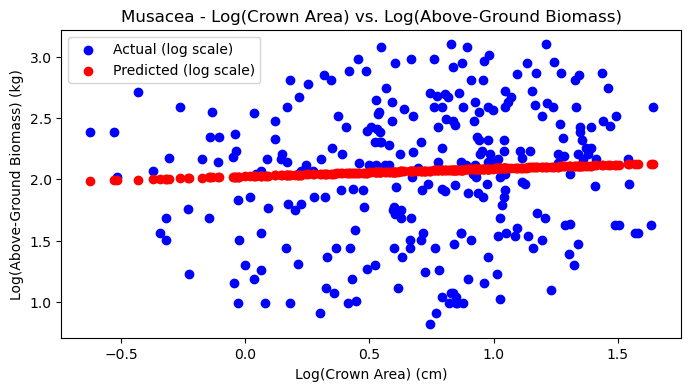

Species: Otra variedad
Mean Squared Error: 0.8383978532686528
R^2 Score: -0.06180831510063367
Intercept (a): 14.617736288270953
Coefficient (b): 0.01902529308060644


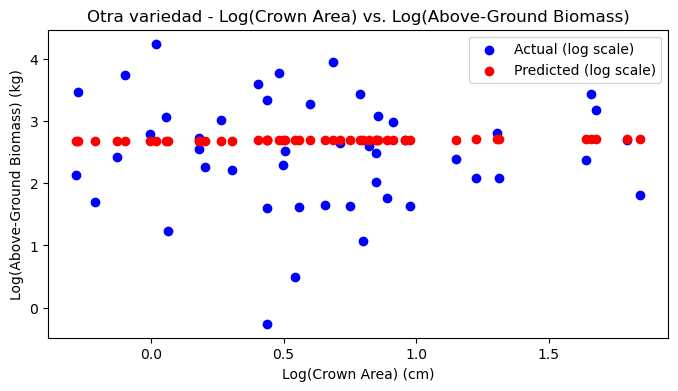

In [92]:
# List of unique species
species_list = df_cleaned['name'].unique()

# Fit and evaluate models for each species, and extract coefficients
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = au.fit_and_evaluate_log_log_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)


### Cross-Val Scores

In [93]:
def calculate_cross_val_score(models):
    for species, model in models.items():
        species_data = df_cleaned[df_cleaned['name'] == species]
        X = np.log(species_data[['bbox_area']])
        y = np.log(species_data['AGB'])
        
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        print(f'Species: {species}')
        print(f'Cross-Validation R^2 Scores: {scores}')
        print(f'Mean R^2 Score: {scores.mean()}')
    return scores

In [94]:
calculate_cross_val_score(models)

Species: Cacao
Cross-Validation R^2 Scores: [-0.04693606 -0.28146568  0.00532233 -3.53098838 -0.61900812]
Mean R^2 Score: -0.8946151821682973
Species: Guaba
Cross-Validation R^2 Scores: [-0.53568061 -0.32874697 -0.07838773 -0.03160944 -0.02208767]
Mean R^2 Score: -0.1993024847997938
Species: Mango
Cross-Validation R^2 Scores: [-0.90175442 -0.38086558 -0.57420185 -0.33703279 -0.00732994]
Mean R^2 Score: -0.440236916004291
Species: Musacea
Cross-Validation R^2 Scores: [-0.15286049  0.00058154 -0.26048636 -0.09993098 -0.54795571]
Mean R^2 Score: -0.21213040010380807
Species: Otra variedad
Cross-Validation R^2 Scores: [-0.02279887 -0.79976707 -0.17937587 -0.02139414 -0.12985778]
Mean R^2 Score: -0.2306387464496465


array([-0.02279887, -0.79976707, -0.17937587, -0.02139414, -0.12985778])